# TMM stability against changes in initialization

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
import jax

import jax.random as jrandom
import numpy as np
import matplotlib.pyplot as plt
import studenttmixture
import scipy
import tqdm
import sklearn.mixture

# own code
import corc.datasets2d
# import src.corc.datasets_refactor as datasets2d
from corc.graph_metrics import tmm_gmm_neb
import corc.tmm_plots as tmm_plots
import corc.utils

In [3]:
datasets = corc.datasets2d.DATASETS
print(f"there are {len(datasets)} datasets")

data_X, data_y = datasets['Moons']()
print(f'current dataset has {len(set(data_y.tolist()))} classes')

there are 19 datasets
current dataset has 2 classes


In [10]:
tmm_model = corc.graph_metrics.neb.NEB(
    latent_dim=2,
    data=data_X,
    labels=data_y,
    optimization_iterations=100,
    seed=42+10
)
tmm_model.fit(data=data_X)
# tmm_models.append(tmm_model)

After filtering 15 components, we are left with 12 components


tmm: 100%|██████████| 66/66 [01:29<00:00,  1.35s/it]


In [ ]:
neb_iterations=50
num_models=4

tmm_models = list()
for i in range(num_models):
    tmm_model = corc.graph_metrics.neb.NEB(
        latent_dim=2,
        data=data_X,
        labels=data_y,
        optimization_iterations=neb_iterations,
        seed=42+i
    )
    tmm_model.fit(data=data_X)
    tmm_models.append(tmm_model)

tmm_model = tmm_models[0]

After filtering 15 components, we are left with 13 components


tmm: 100%|██████████| 78/78 [00:56<00:00,  1.37it/s]


After filtering 15 components, we are left with 13 components


tmm: 100%|██████████| 78/78 [00:41<00:00,  1.88it/s]


After filtering 15 components, we are left with 13 components


tmm: 100%|██████████| 78/78 [00:36<00:00,  2.14it/s]


After filtering 15 components, we are left with 13 components


tmm: 100%|██████████| 78/78 [00:35<00:00,  2.17it/s]


In [22]:
tmm_model = tmm_models[-2]

In [5]:
pairs = tmm_model.get_merged_pairs(2)
len(pairs)

10

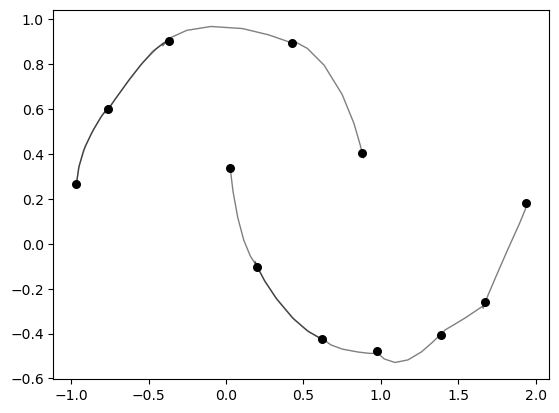

In [13]:
tmm_model.plot_graph()

In [ ]:
import pickle 
pickle.load("cache/noisy_moons_TMM-NEB.pickle")

[(0, 4),
 (1, 2),
 (1, 10),
 (1, 11),
 (3, 9),
 (4, 5),
 (5, 10),
 (6, 7),
 (7, 9),
 (8, 9)]

In [36]:
a,b = tmm_model.get_thresholds_and_cluster_numbers()

In [37]:
b[2]

array([0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1], dtype=int32)

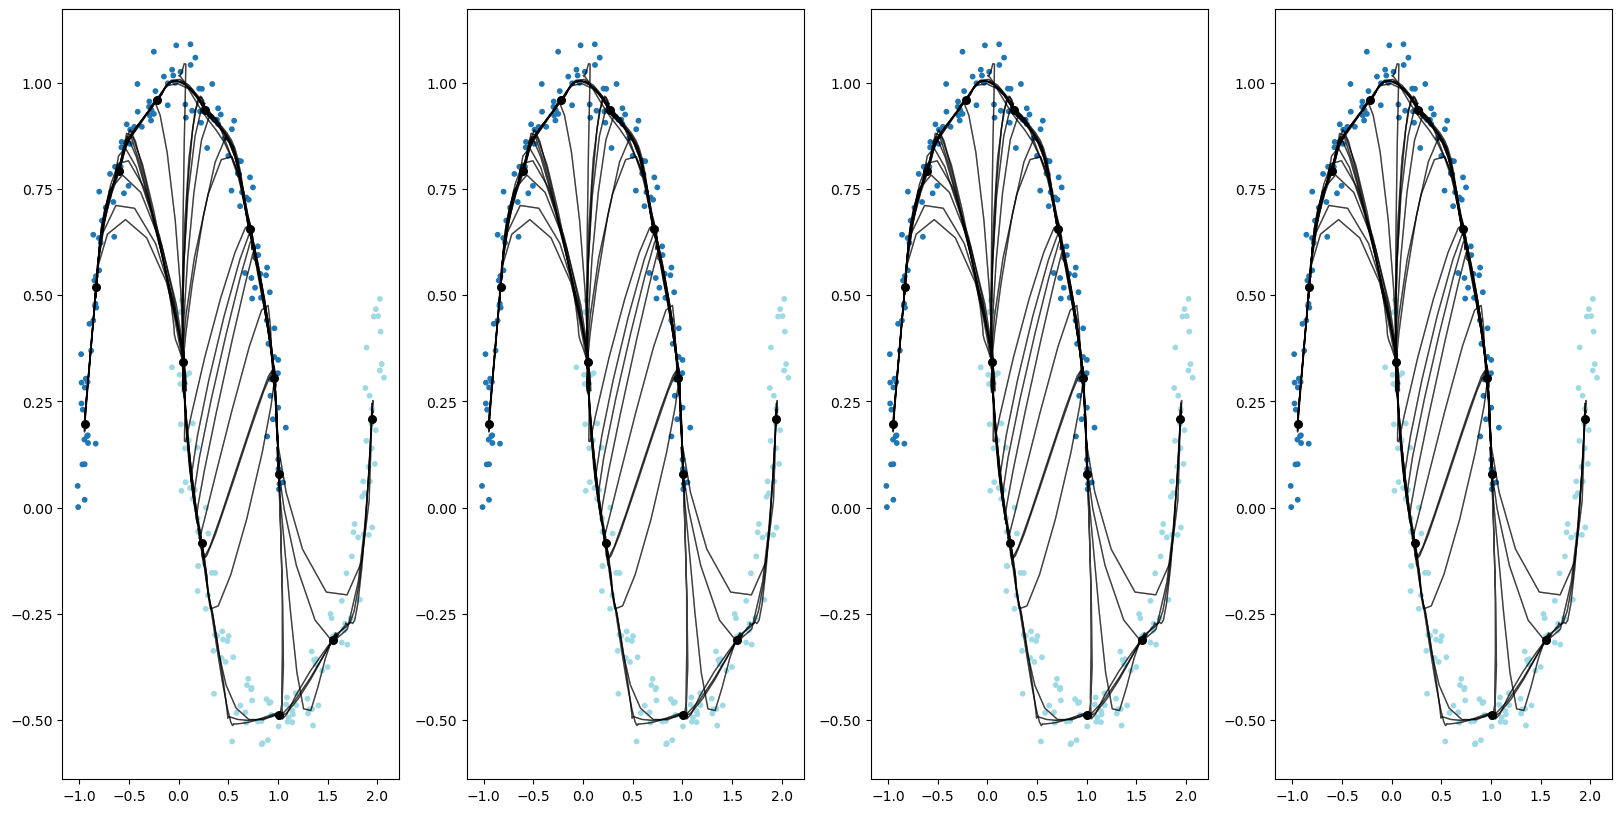

In [5]:
plt.figure(figsize=(20, 10))

for i, tmm_model in enumerate(tmm_models):
    plt.subplot(1 + (len(tmm_models) // 5), min(len(tmm_models),5), i+1)
    # draw background for MEP plots
    image_resolution = 128
    linspace_x = np.linspace(
        data_X[:, 0].min() - 0.1, data_X[:, 0].max() + 0.1, image_resolution
    )
    linspace_y = np.linspace(
        data_X[:, 1].min() - 0.1, data_X[:, 1].max() + 0.1, image_resolution
    )
    XY = np.stack(np.meshgrid(linspace_x, linspace_y), -1)
    tmm_probs = tmm_model.mixture_model.score_samples(
        XY.reshape(-1, 2)
    ).reshape(image_resolution, image_resolution)
    # plt.contourf(
    #     linspace_x,
    #     linspace_y,
    #     tmm_probs,
    #     levels=20,
    #     cmap="coolwarm",
    #     alpha=0.5,
    # )
    
    # extracting the predictions
    num_classes = len(np.unique(data_y))
    y_pred = tmm_model.predict_with_target(data=data_X, target_number_classes=num_classes)
    
    # draw points
    y_pred_permuted = corc.utils.reorder_colors(y_pred, data_y)
    plt.scatter(data_X[:, 0], data_X[:, 1], s=10, c=y_pred_permuted, cmap='tab20')
    
    tmm_model.plot_graph()

In [6]:
len(np.unique(tmm_model.labels))

2

In [42]:
adj = tmm_model._get_adjacency_matrix()
np.fill_diagonal(adj, 0)
my_adj = adj>0.4

In [37]:
adj_to_be_merged = scipy.sparse.coo_matrix(adj >= 0.4)

In [43]:
upper_triangle_indices = np.triu_indices(my_adj.shape[0], k=1)
nonzero_upper_triangle_indices = np.nonzero(my_adj[upper_triangle_indices])

In [47]:
indices = [(i, j) for i, j in zip(*np.nonzero(my_adj)) if i < j]

In [48]:
indices

[(1, 12), (4, 9)]

In [24]:
tmms = list()
for i in tqdm.trange(10, desc='tmm'):
    tmm = studenttmixture.EMStudentMixture(
        n_components=15,
        n_init=5,
        fixed_df=True,
        df=1.0,
        init_type="k++",
        random_state=42+i
    )
    tmm.fit(np.array(data_X, dtype=np.float64))
    tmms.append(tmm)

gmms = list()
for i in tqdm.trange(10, desc='gmm'):
    gmm = sklearn.mixture.GaussianMixture(
        n_components=15,
        n_init=5,
        random_state=42+i,
        init_params='k-means++',
        covariance_type='full',
    )
    gmm.fit(np.array(data_X, dtype=np.float64))
    gmms.append(gmm)

gmm: 100%|██████████| 10/10 [00:00<00:00, 28.84it/s]


In [25]:
gmm = gmms[1]
gmm.weights_

array([0.02802792, 0.04443057, 0.16666667, 0.10048968, 0.05213019,
       0.092565  , 0.13863874, 0.11556944, 0.07410167, 0.06699151,
       0.04754497, 0.03519153, 0.01046204, 0.02052341, 0.00666666])

In [26]:
iterations = 100
adjacencies = list()
raws = list()
all_paths = list()
for i in range(10):
    adjacency, raw_adjacency, paths, _, _ = tmm_gmm_neb.compute_neb_paths(gmms[i], iterations=iterations)
    adjacencies.append(adjacency)
    raws.append(raw_adjacency)
    all_paths.append(paths)
    

gmm:  55%|█████▌    | 58/105 [01:04<00:52,  1.12s/it]


KeyboardInterrupt: 

In [7]:
centers = list()
for i in tqdm.trange(10):
    adjacency = adjacencies[i]
    thresholds = np.unique(adjacency)
    thresholds = sorted(thresholds.tolist())
    for threshold in thresholds:
        tmp_adj = np.array(adjacency >= threshold, dtype=int)
        n_components, clusters = scipy.sparse.csgraph.connected_components(tmp_adj)
        
        gt_components = len(np.unique(data_y))# target number of components
        if n_components == gt_components: 
            locations = tmms[i].location
            cluster_means = [np.mean(locations[clusters == i], axis=0) for i in range(gt_components)]
            centers.append(np.array(cluster_means))

  0%|          | 0/10 [00:00<?, ?it/s]


IndexError: list index out of range

<function matplotlib.pyplot.show(close=None, block=None)>

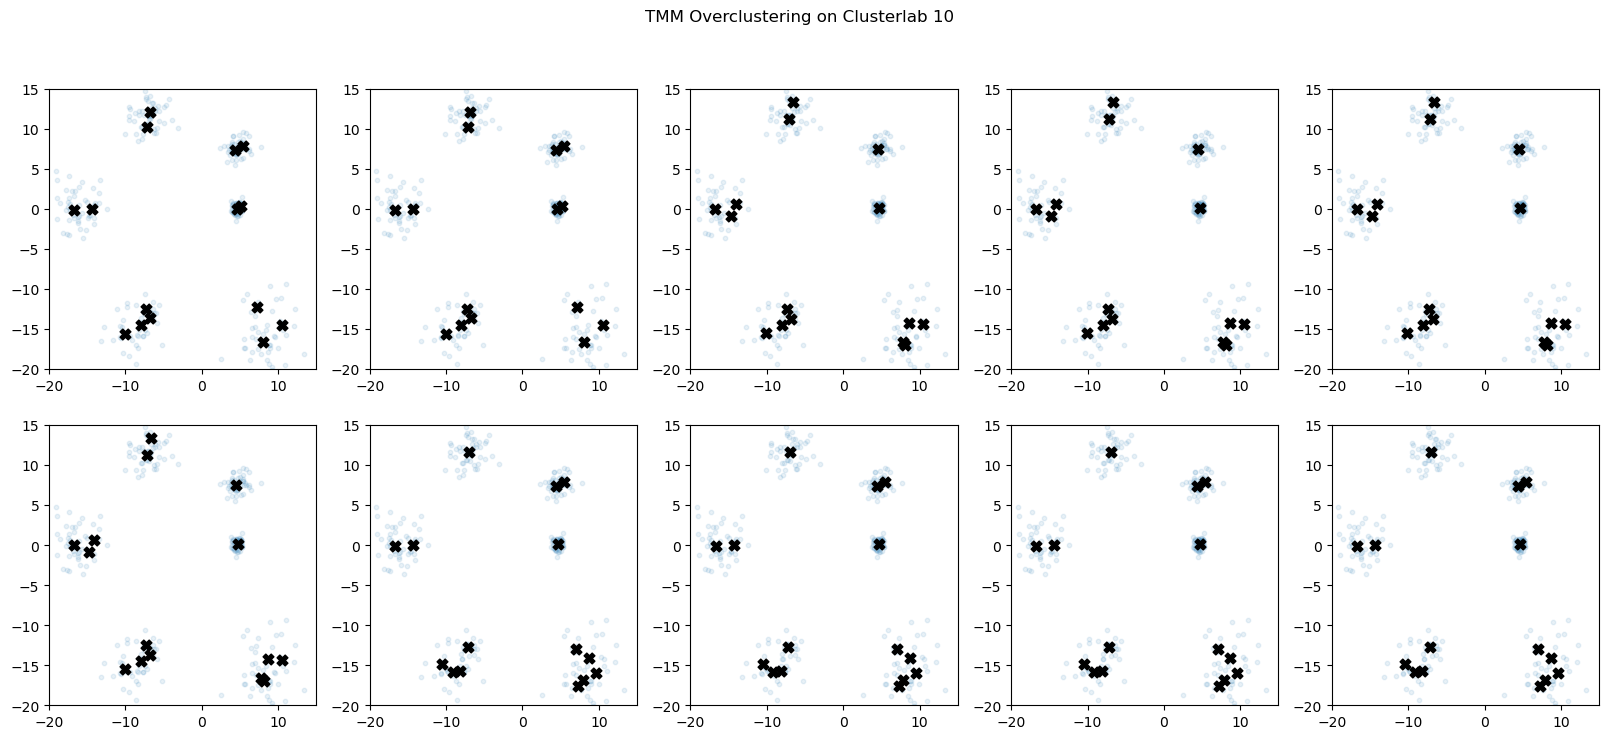

In [79]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 8))
fig.suptitle('TMM Overclustering on Clusterlab 10')
for i in range(2):
    for j in range(5):
        axes[i,j].scatter(data_X[:, 0], data_X[:, 1], s=10, label="raw data", alpha=0.1)
        
        axes[i,j].scatter(tmms[5*i+j].location[:, 0], tmms[5*i+j].location[:, 1], color="black", marker="X", s=60)
        axes[i,j].set_xlim(-20,15)
        axes[i,j].set_ylim(-20,15)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

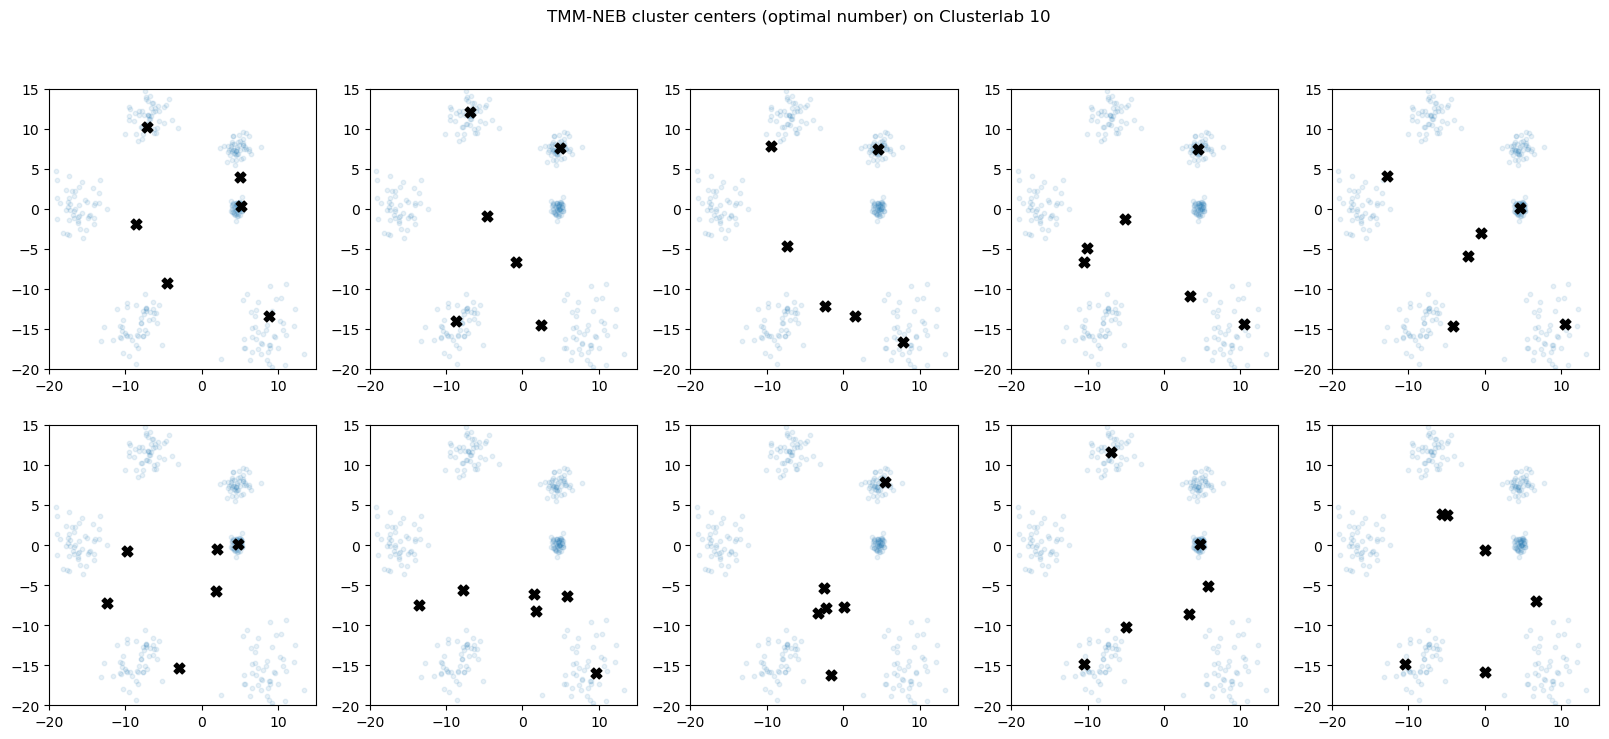

In [80]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 8))
fig.suptitle('TMM-NEB cluster centers (optimal number) on Clusterlab 10')
for i in range(2):
    for j in range(5):
        axes[i,j].scatter(data_X[:, 0], data_X[:, 1], s=10, label="raw data", alpha=0.1)

        axes[i,j].scatter(centers[5*i+j][:, 0], centers[5*i+j][:, 1], color="black", marker="X", s=60)
        axes[i,j].set_xlim(-20,15)
        axes[i,j].set_ylim(-20,15)
plt.show

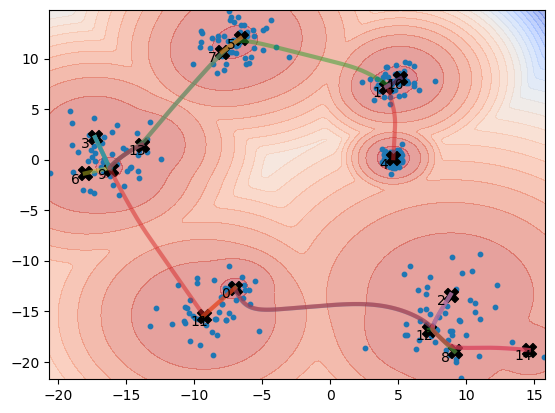

In [81]:
selection = tmm_plots.compute_mst_edges(raws[7])
tmm_plots.plot_field(data_X, gmms[7], paths=all_paths[7], selection=selection)